In [10]:
# Importing the libraries
import pandas as pd
import numpy as np
from IPython.display import display

import matplotlib.pyplot as plt
import re
import string

import spacy
from textblob import TextBlob

from collections import Counter

import seaborn as sns
import plotly.express as px

sns.set(style="darkgrid")

# Load spaCy model
nlp = spacy.load("en_core_web_sm")
stop_words = nlp.Defaults.stop_words

In [11]:
# Reading data from csv file
dataset = pd.read_csv("twitterEndSars.csv")
dataset.head()

,Unnamed: 0,url,date,content,id,username,outlinks,outlinksss,tcooutlinks,tcooutlinksss
0,0,https://twitter.com/hurbhiaghelee/status/13852...,2021-04-22 18:28:26+00:00,This is the highest form of intimidation\nWhat...,1385299471123238912,hurbhiaghelee,['https://twitter.com/AmaiweLove/status/138519...,https://twitter.com/AmaiweLove/status/13851900...,['https://t.co/xxdTK0BmQB'],https://t.co/xxdTK0BmQB
1,1,https://twitter.com/AlukoJoseph5/status/138524...,2021-04-22 15:07:05+00:00,Why is it taking a life long time for @MBuhari...,1385248799770267650,AlukoJoseph5,[],NaN,[],NaN
2,2,https://twitter.com/omofuma_Elijah/status/1385...,2021-04-22 10:13:20+00:00,"Even Desmond Elliot is quite , ,,, what is tha...",1385174876428902400,omofuma_Elijah,['https://twitter.com/vhic_tore/status/1385141...,https://twitter.com/vhic_tore/status/138514152...,['https://t.co/RsVQ4N8LwM'],https://t.co/RsVQ4N8LwM
3,3,https://twitter.com/FelixOdohoedi/status/13851...,2021-04-22 09:48:04+00:00,When will CBN freeze the account of @DrIsaPant...,1385168517104869378,FelixOdohoedi,['https://twitter.com/Imudia_se2/status/138495...,https://twitter.com/Imudia_se2/status/13849543...,['https://t.co/r3vxrbkLdn'],https://t.co/r3vxrbkLdn
4,4,https://twitter.com/adekzee1/status/1385164392...,2021-04-22 09:31:40+00:00,@Obiejazzyup @YeleSowore @MBuhari @EndSars @mb...,1385164392447238145,adekzee1,[],NaN,[],NaN


In [12]:
# Data shape
dataset.shape

(9737, 10)

In [13]:
# Selecting relevant columns
needed_columns = ['username', 'date', 'content']
dataset = dataset[needed_columns]
dataset.head()

,username,date,content
0,hurbhiaghelee,2021-04-22 18:28:26+00:00,This is the highest form of intimidation\nWhat...
1,AlukoJoseph5,2021-04-22 15:07:05+00:00,Why is it taking a life long time for @MBuhari...
2,omofuma_Elijah,2021-04-22 10:13:20+00:00,"Even Desmond Elliot is quite , ,,, what is tha..."
3,FelixOdohoedi,2021-04-22 09:48:04+00:00,When will CBN freeze the account of @DrIsaPant...
4,adekzee1,2021-04-22 09:31:40+00:00,@Obiejazzyup @YeleSowore @MBuhari @EndSars @mb...


In [14]:
# Categorizing username
dataset.username = dataset.username.astype('category')
dataset.username = dataset.username.cat.codes
dataset.date = pd.to_datetime(dataset.date).dt.date  # post_date
dataset.head()

,username,date,content
0,4928,2021-04-22,This is the highest form of intimidation\nWhat...
1,382,2021-04-22,Why is it taking a life long time for @MBuhari...
2,5768,2021-04-22,"Even Desmond Elliot is quite , ,,, what is tha..."
3,1441,2021-04-22,When will CBN freeze the account of @DrIsaPant...
4,4045,2021-04-22,@Obiejazzyup @YeleSowore @MBuhari @EndSars @mb...


In [24]:
# Pre-processing text colmns

def preprocess_texts(dataset):
    #removing urls
    def remove_url(text):
        return re.sub(r'http\S+', '', str(text))
    
    #removing punctuations
    def remove_punctuation(text):
        return text.translate(str.maketrans('', '', string.punctuation))
    
    #removing stopwords (is, they, them, to, the etc)
    def remove_stopwords(text):
        return ' '.join([word for word in text.split() if word not in stop_words])
    
    # Combine all preprocessing steps
    def preprocess(text):
        text = remove_url(text)
        text = text.lower()
        text = remove_punctuation(text)
        text = remove_stopwords(text)
        return text

    dataset['preprocess_content'] = dataset['content'].apply(preprocess)
    
    return dataset

dataset = preprocess_texts(dataset)
dataset.head()

,username,date,content,preprocess_content
0,4928,2021-04-22,This is the highest form of intimidation\nWhat...,highest form intimidation offence commit answe...
1,382,2021-04-22,Why is it taking a life long time for @MBuhari...,taking life long time mbuhari sack drisapantam...
2,5768,2021-04-22,"Even Desmond Elliot is quite , ,,, what is tha...",desmond elliot womans look like jellof rice wa...
3,1441,2021-04-22,When will CBN freeze the account of @DrIsaPant...,cbn freeze account drisapantami cbn quick free...
4,4045,2021-04-22,@Obiejazzyup @YeleSowore @MBuhari @EndSars @mb...,obiejazzyup yelesowore mbuhari endsars mbujari...


In [25]:
# remove emoticons, symbols or flags by their codes
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# applying remove_emoji function on tweets
dataset['preprocess_content']=dataset['preprocess_content'].apply(lambda x: remove_emoji(x))
dataset.head()

,username,date,content,preprocess_content
0,4928,2021-04-22,This is the highest form of intimidation\nWhat...,highest form intimidation offence commit answe...
1,382,2021-04-22,Why is it taking a life long time for @MBuhari...,taking life long time mbuhari sack drisapantam...
2,5768,2021-04-22,"Even Desmond Elliot is quite , ,,, what is tha...",desmond elliot womans look like jellof rice wa...
3,1441,2021-04-22,When will CBN freeze the account of @DrIsaPant...,cbn freeze account drisapantami cbn quick free...
4,4045,2021-04-22,@Obiejazzyup @YeleSowore @MBuhari @EndSars @mb...,obiejazzyup yelesowore mbuhari endsars mbujari...


In [26]:
# Tokenization
texts = dataset.preprocess_content

def tokenize(text):
    doc = nlp(text)
    return [token.text for token in doc]

texts_tokens = texts.apply(tokenize)
texts_tokens

0       [highest, form, intimidation, offence, commit,...
1       [taking, life, long, time, mbuhari, sack, dris...
2       [desmond, elliot, womans, look, like, jellof, ...
3       [cbn, freeze, account, drisapantami, cbn, quic...
4       [obiejazzyup, yelesowore, mbuhari, endsars, mb...
                              ...                        
9732    [yomishogunle, policengpcrru, policeng, apolog...
9733    [government, policeng, policengpcrru, pretend,...
9734    [endsars, issues, ending, sars, issue, reorien...
9735    [u, handsome, suspect, wear, new, shoe, suspec...
9736    [ca, nt, create, change, twitter, organise, ma...
Name: preprocess_content, Length: 9737, dtype: object

In [27]:
# Flatten the list of tokens and count the frequency of each token
all_tokens = [token for sublist in texts_tokens for token in sublist]
token_freq = Counter(all_tokens)

# Get the 50 most common words
common_tokens = token_freq.most_common(50)

# Convert to a DataFrame for easier plotting
common_tokens_df = pd.DataFrame(common_tokens, columns=['Token', 'Frequency'])

# Plotting with Plotly
fig = px.bar(common_tokens_df, x='Token', y='Frequency', title='50 Most Common Words')
fig.update_layout(xaxis_tickangle=-90)
fig.show()

In [28]:
# Lemmatization
def lemmatize(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

texts_lemmatized = texts.apply(lemmatize)
texts_lemmatized


0       high form intimidation offence commit answer u...
1       take life long time mbuhari sack drisapantami ...
2       desmond elliot woman look like jellof rice way...
3       cbn freeze account drisapantami cbn quick free...
4       obiejazzyup yelesowore mbuhari endsar mbujari ...
                              ...                        
9732    yomishogunle policengpcrru policeng apologise ...
9733    government policeng policengpcrru pretend see ...
9734    endsar issue end sar issue reorientation niger...
9735    u handsome suspect wear new shoe suspect hold ...
9736    can not create change twitter organise march 3...
Name: preprocess_content, Length: 9737, dtype: object

In [34]:
# Load ABSA pipeline from Hugging Face
from transformers import pipeline
absa_pipeline = pipeline("sentiment-analysis", model="finiteautomata/bertweet-base-sentiment-analysis")

# Sentiment analysis using ABSA
def get_absa_sentiment(text):
    result = absa_pipeline(text)
    return result[0]['label'].lower()

dataset['sentiment'] = texts_lemmatized.apply(get_absa_sentiment)

pytorch_model.bin: 100%|██████████| 540M/540M [02:16<00:00, 3.95MB/s] 
tokenizer_config.json: 100%|██████████| 338/338 [00:00<00:00, 345kB/s]
vocab.txt: 100%|██████████| 843k/843k [00:00<00:00, 1.07MB/s]
bpe.codes: 100%|██████████| 1.08M/1.08M [00:00<00:00, 1.18MB/s]
added_tokens.json: 100%|██████████| 22.0/22.0 [00:00<?, ?B/s]
special_tokens_map.json: 100%|██████████| 167/167 [00:00<?, ?B/s] 


In [29]:
# Sentiment analysis using TextBlob
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

sentiments = texts_lemmatized.apply(get_sentiment)
sentiments

0       0.160000
1       0.050000
2       0.011111
3       0.333333
4       0.400000
          ...   
9732   -0.400000
9733    0.000000
9734    0.099375
9735    0.234091
9736    0.000000
Name: preprocess_content, Length: 9737, dtype: float64

In [30]:
# Labeling sentiment
def label_sentiment(polarity):
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

dataset['sentiment'] = sentiments.apply(label_sentiment)
dataset.head()

,username,date,content,preprocess_content,sentiment
0,4928,2021-04-22,This is the highest form of intimidation\nWhat...,highest form intimidation offence commit answe...,positive
1,382,2021-04-22,Why is it taking a life long time for @MBuhari...,taking life long time mbuhari sack drisapantam...,positive
2,5768,2021-04-22,"Even Desmond Elliot is quite , ,,, what is tha...",desmond elliot womans look like jellof rice wa...,positive
3,1441,2021-04-22,When will CBN freeze the account of @DrIsaPant...,cbn freeze account drisapantami cbn quick free...,positive
4,4045,2021-04-22,@Obiejazzyup @YeleSowore @MBuhari @EndSars @mb...,obiejazzyup yelesowore mbuhari endsars mbujari...,positive


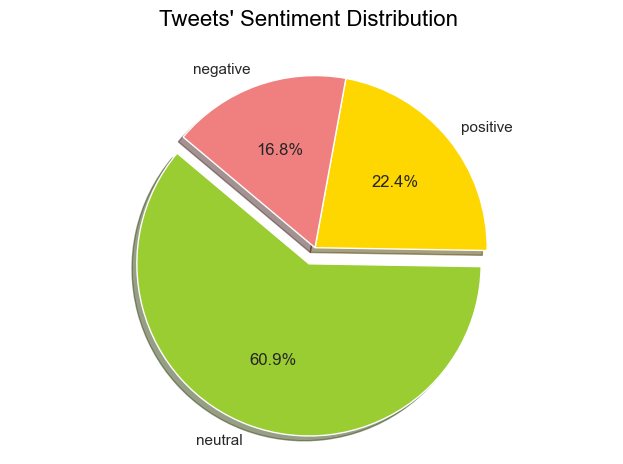

In [32]:
# Sentiment distribution
sentiment_dist = dataset['sentiment'].value_counts()

plt.pie(sentiment_dist, labels=sentiment_dist.index, explode=(0.1, 0, 0),
        colors=['yellowgreen', 'gold', 'lightcoral'],
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Tweets' Sentiment Distribution \n", fontsize=16, color='Black')
plt.axis('equal')
plt.tight_layout()
plt.show()